
TFG

Este es el codigo del tfg de Borja Jimeno

En esta primera celda vamos a definir todas las funciones y variables que necesitaremos para calcular el ritmo teórico. Cada función está explicada al inicio y cada variable tiene asociadas sus unidades en un comentario a la derecha.  

Para la realización de las funciones se ha tomado como referencia:  
-El pdf ('rateTutorial_MMartinez_TAE25.pdf)    
-El capítulo 7 de la Tesis de María ('tesisMaria_chap7.pdf')   
-El artículo 'Inelastic and Elastic Scattering of 187-Mev Electrons from Selected Even-Even Nuclei - Richard Helm - PHISICAL REVIEW VOLUME 104, NUMBER 5 DECEMBER 1, 1956'  
-Para calcular el Quenching Factor, Sección 4.3.2 de la tesis de Tamara Pardo Yanguas ('Tesis-Tamara.pdf')

In [98]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18

unitsvearth = 0 # km/s -> 0 , m/s -> 1

#ctes

mn=0.9315               # Masa nucleon (GeV/c^2)
NA=6.022e23             # Numero de Avogadro
c=299792458             # Velocidad luz (m/)s
hbar = 6.582e-16        # eV*s
sqrtpi=m.sqrt(m.pi)     # Raíz de pi

#Halo DM
rho=0.3                 # Densidad local de materia oscura Gev/c2/cm3
vesc=544                # Velocidad de escape de la galaxia (km/s)

#Velocidad del sol
u1=np.array([ 0.9941, 0.1088, 0.0042])
u2=np.array([-0.0504, 0.4946, -0.8677])
v0=np.array([0,238,0])                      # Velocidad en reposo local standar (km/s)
v0n=np.sqrt(v0.dot(v0))                     # Norma de la Velocidad en reposo local standar (km/s)
omega=0.0172                                # Frecuencia angular en d-1 (2pi/365)
vpec=np.array([11.1,12.2,7.3])              # Velocidad peculiar (km/s)
vsun=v0+vpec                                # Velocidad del Sol (km/s)
vorb=29.8                                   # Velocidad orbital de la Tierra (km/s)
timeMax=72.9                                # Dia de la máxima velocidad de la tierra: 2 de junio, empezando desde el 22 de marzo.
timeMin=255.5                               # Dia de la mínima velocidad de la tierra: empezando desde el 22 de marzo.
timeAvg=(timeMax+timeMin)/2.                # Dia promedio (El que usaremos para calcular el ritmo)
ene=np.arange(0,100,1)                      # Array de energías de 0 a 100 MeV en intervalos de 1 MeV
time=np.arange(0,365,1)                     # Array de dias, 365 dias en intervalos de 1 dia




#################
# Funcion de Bessel de primera especie
#################
def j1(x):
    return(m.sin(x)/(x*x)-m.cos(x)/x)

#################
# Velocidad de la tierra, en km/s
#################
def vearth(t): 
    v = vsun + vorb*(m.cos(omega*t)*u1+m.sin(omega*t)*u2)
    return m.sqrt(v.dot(v))
    
#################
# Velocidad minima de la DM para un umbral E (en km/s)
# E en keV
# A: Numero másico
# mW: Masa del Wimp en GeV/c^2
#################
def vmin(E,A,mW): 
    res=E*1e-6*(A*mn+mW)*(A*mn+mW)/(2*A*mn*mW*mW)
    res=np.sqrt(res)*c/1000
    return res

#################
# mean inverse speed function (Función de velocidad inversa media) (en s/km)
# E en keV
# t: Tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
#################
def eta(E,t,A,mW):
    x=vmin(E,A,mW)/v0n
    y=vearth(t)/v0n
    z=vesc/v0n
    if(x>(z+y)): 
        return 0
    else:
        N=m.erf(z)-2*z/np.sqrt(np.pi)*m.exp(-z*z)
        if((x>(z-y)) and ((z+y) >= x)):
            return 1/(2*y*v0n*N)*(m.erf(z)-m.erf(x-y)-2/np.sqrt(np.pi)*(z+y-x)*np.exp(-z*z))
        if((x>=(0)) and ((z-y) >= x)):
            return 1/(2*y*v0n*N)*(m.erf(x+y)-m.erf(x-y)-4/np.sqrt(np.pi)*y*np.exp(-z*z))
        
#################
# Factor de Forma
# E en keV
# A: Numero másico
#################
def FF(E,A):
    if E==0:
        E=1e-12
    s=1
    R=1.2*A**(0.3333)
    
    R1=m.sqrt(R*R-5*s*s)
    R1*=1e-6/hbar/c

    q2=2*E*A*mn*1e-6
    x=m.sqrt(q2)*R1
    aux=q2*s*s*1e-6/hbar/c*1e-6/hbar/c
    F2=((3*j1(x)/(x))**2)*m.exp(-aux)
    return F2

#################
# Ritmo diferencial
# E en keV
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
#################
def rate(E,t,A,mW,sigmaSI):
    mN=A*mn
    Mdet=NA*mN*1000 # GeV/c2/kg
    mu_n=mW*mn/(mW+mn)
    retval=Mdet*rho/2./mW*A*A/mu_n/mu_n*sigmaSI*c*c
    retval*=8.64e-3 # to convert to counts/kg/keV/d
    retval*=365 # convert to counts/kg/keV/y
    retval*=FF(E,A)
    retval*=eta(E,t,A,mW)
    return retval

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en c/kg/y)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRate(Ei,Ef,t,A,mW,sigmaSI):
  ene=np.arange(Ei,Ef,0.1)
  rates=np.array([rate(e,t,A,mW,sigmaSI) for e in ene])
  return rates.sum()*0.1

#########################
#########################
# Ritmo en funcon del tiempo
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def ratevsTime(Ei,Ef,A,mW,sigmaSI):
    dias = np.arange(0,365)
    ritmos_dias=([totalRate(Ei,Ef,t,A,mW,sigmaSI) for t in dias])
    return ritmos_dias



# FUNCIONES ESPECIFICAS PARA NAI

#########################
#########################
# Ritmo en funcon del tiempo
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def ratevsTimeNaI(Ei,Ef,mW,sigmaSI):
    dias = np.arange(0,365)
    ritmos_dias=([totalRateNaI(Ei,Ef,t,mW,sigmaSI) for t in dias])
    return ritmos_dias
       
#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en c/kg/y)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRateNaI(Ei,Ef,t,mW,sigmaSI):
  ene=np.arange(Ei,Ef,0.1)
  rates=np.array([RateNaI(e,t,mW,sigmaSI) for e in ene])
  return rates.sum()*0.1

#########################
#########################
# Ritmo diferencial
# E en keV
# t: tiempo en dias desde el 22 de marzo
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def RateNaI(E,t,mW,sigmaSI):
    ratesNa=rate(E,t,23,mW,sigmaSI)
    ratesI=rate(E,t,127,mW,sigmaSI)
    return (23.*ratesNa+127.*ratesI)/(23.+127.)


# FUNCIONES TENIENDO EN CUENTA EL FACTOR QUENCHING

#FACTOR QUENCHING
#   Devuelve el factor quenching del NaI evaluado en electron-equivalent energy ee
#   Parametros
# ee : float o array-like de Electron-equivalent energy.
# Devuelve: float or np.ndarray
# Quenching factor QF(ee), interpolado linealmente en (x=ER*QF, y=QF)
# Construido para ER in [1, 100] with N=200 points.
# From modified Lindhard Fit of Na QF data (Tamara's thesis)
# k = 0.072, alpha = 0.007
# epsilon = alpha * ER
# g(ER)=3*pow(epsilon, 0.15) + 0.7*pow(epsilon,0.6) + epsilon
# QF(ER)=k*g(ER)/(1+k*g(ER))
# Eee=ER*QF(ER)

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)

    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf

    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)

    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)

    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf

    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

#################
# Ritmo diferencial (Teniendo en cuenta el Quenching, Energía en ee)
# E en keV
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
#################
def rate_ee(Eee,t,A,mW,sigmaSI,Q=1):
    E=Eee/Q
    mN=A*mn
    Mdet=NA*mN*1000 # GeV/c2/kg
    mu_n=mW*mn/(mW+mn)
    retval=Mdet*rho/2./mW*A*A/mu_n/mu_n*sigmaSI*c*c
    retval*=8.64e-3 # to convert to counts/kg/keV/d
    retval*=365 # convert to counts/kg/keV/y
    retval*=FF(E,A)
    retval*=eta(E,t,A,mW)
    retval/=Q
    return retval

#########################
#########################
# Ritmo diferencial en detector NaI (en c/kevee/kg/y) 
# E: en keVee
# t: tiempo en dias desde el 22 de marzo
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
# QNa es el factor de Quenching a energía Eee(keVee) para Na
# QI es el factor de Quenching a energía Eee(keVee) para I
def rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
  # convert Eee to keV_NR
  rateNa = rate_ee(Eee,t,23,mW,sigmaSI,QNa)
  rateI = rate_ee(Eee,t,127,mW,sigmaSI,QI)
 
  return (rateNa*23.+rateI*127.)/(23.+127.)

#########################
#########################
# Ritmo total, integrado entre Eiee y Efee (en c/kg/y)
# Eiee, Efee: Energías inicial y final en keVee
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
  energy_ee = np.arange(Eiee,Efee,0.1)
  qfNa = getQFNa(energy_ee)
  qfI = getQFI(energy_ee)
  rates = np.array([
        rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)
    ])

  return rates.sum()*0.1


Dia 1
En este primer apartado sacamos graficas para familiarizarnos con las funciones definidas en la parte superior.
Calculamos el ritmo teórico diferencial para diferentes targets. En este caso para Na, I y NaI.

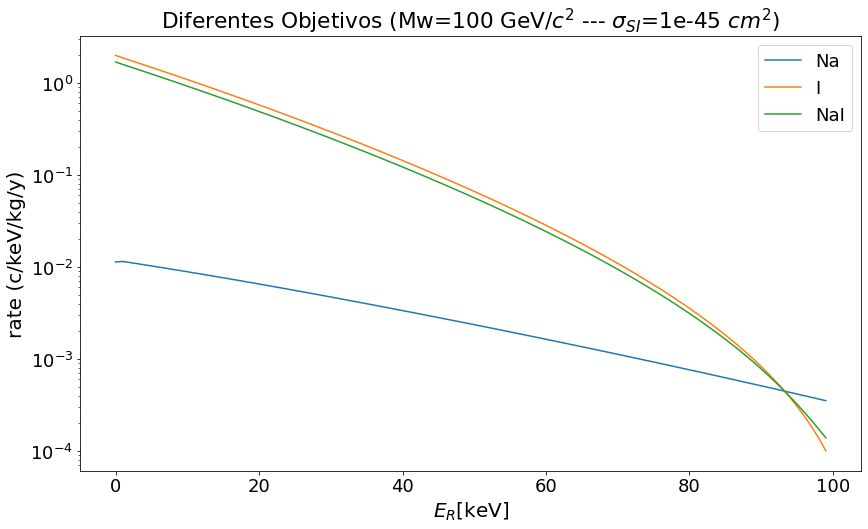

In [99]:

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW=100 #masa wimp (geV/c^2)
si=1e-45 #seccion eficaz SI(cm^-2)
ene=np.arange(0,100,1)


rateNa=np.array([rate(e,timeAvg,23,mW,si) for e in ene])
rateI=np.array([rate(e,timeAvg,127,mW,si) for e in ene])
rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(ene,rateNa, label = "Na")
ax.plot(ene,rateI, label = "I")
ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title('Diferentes Objetivos (Mw=' + str(np.round(mW)) + ' GeV/$c^2$ --- $\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")

En esta segunda grafica hemos calculado el ritmo diferencial en funcion de diferentes masas del wimp para un objetivo de NaI

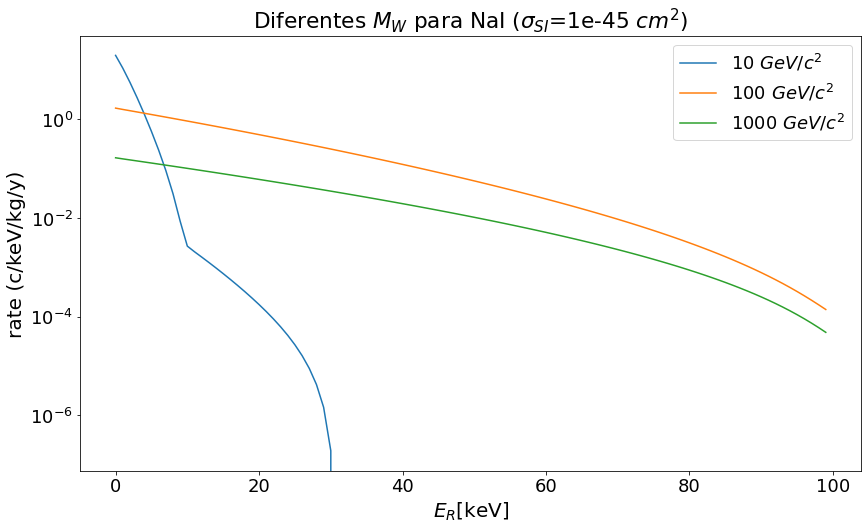

In [100]:

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.


si=1e-45 #seccion eficaz SI(cm^-2)
ene=np.arange(0,100,1)


rateAr10=np.array([RateNaI(e,timeAvg,10,si) for e in ene])
rateAr100=np.array([RateNaI(e,timeAvg,100,si) for e in ene])
rateAr1000=np.array([RateNaI(e,timeAvg,1000,si) for e in ene])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(ene,rateAr10, label = "10 $GeV/c^2$")
ax.plot(ene,rateAr100, label = "100 $GeV/c^2$")
ax.plot(ene,rateAr1000, label = "1000 $GeV/c^2$")
ax.set_title('Diferentes $M_W$ para NaI ($\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")


En esta segunda grafica hemos calculado el ritmo diferencial para dos fechas diferentes par un objetivo de NaI

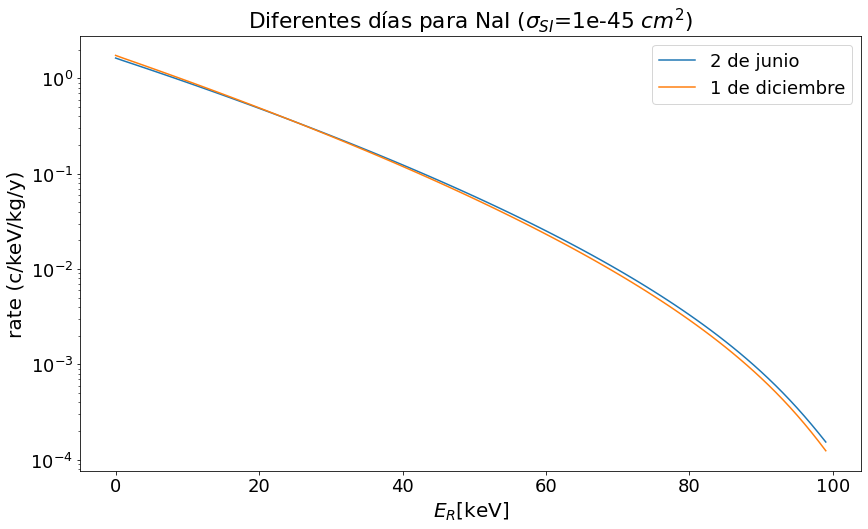

In [101]:

timeMax=72.9 
timeMin=255.5 

mW=100 #masa wimp (geV/c^2)
si=1e-45 #seccion eficaz SI(cm^-2)
ene=np.arange(0,100,1)


rateArtmax=np.array([RateNaI(e,timeMax,mW,si) for e in ene])
rateArtmin=np.array([RateNaI(e,timeMin,mW,si) for e in ene])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(ene,rateArtmax, label = "2 de junio")
ax.plot(ene,rateArtmin, label = "1 de diciembre")

ax.set_title('Diferentes días para NaI ($\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")



En esta grafica hemos representado el ritmo esperado integrando en un intervalo de energías $E \in (0,60)$ $keV$, en funcion del día, se espera ver cierta modulación del ritmo.

R_max = 3.39053e+05
R_min = 333924.0
R_0 = 336522.0
t_max = 256
Error = 0.00979


Text(0.5, 0, 'time (days since March 22)')

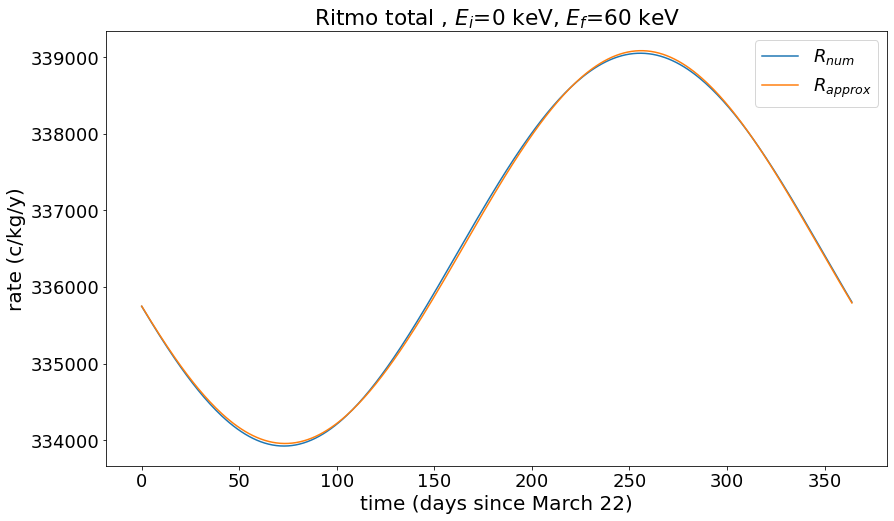

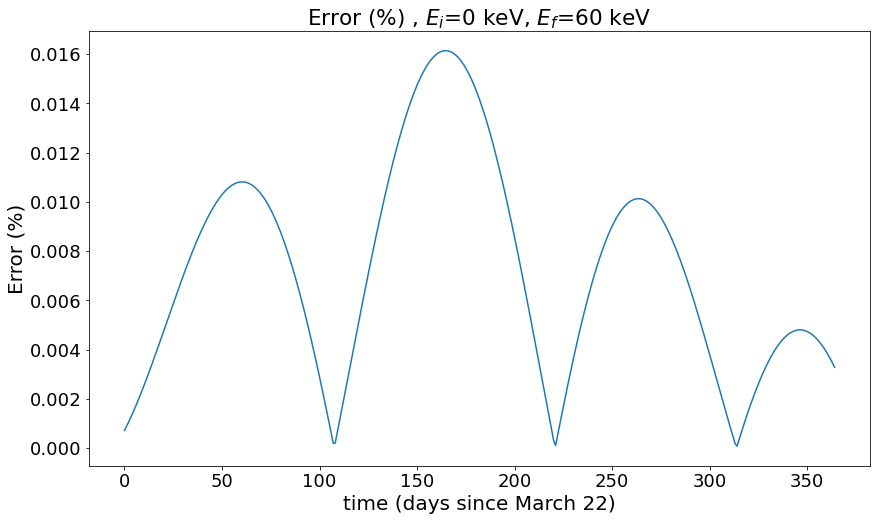

In [102]:

Ei=0
Ef=60

mW=70
si=1e-41 #seccion eficaz SI(cm^-2)
ritmosvstiempos=ratevsTimeNaI(Ei,Ef,mW,si)
R_max=np.max(ritmosvstiempos)
print('R_max = '+str(np.round(R_max)))
R_min=np.min(ritmosvstiempos)
print('R_min = '+str(np.round(R_min)))
R_0=np.mean(ritmosvstiempos)
print('R_0 = '+str(np.round(R_0)))
t_max=np.argmax(ritmosvstiempos)
print('t_max = '+str(t_max))

R_mod=0.5*(R_max-R_min)
omega=2*np.pi/365.

dias = np.arange(0,365)

rapprox=([(R_0+R_mod*np.cos(omega*(t-t_max))) for t in dias])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,ritmosvstiempos, label = "$R_{num}$")
ax.plot(dias,rapprox, label = "$R_{approx}$")
ax.set_title('Ritmo total , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('rate (c/kg/y)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
ax.legend()


err=([np.abs(((1-rapprox[t]/ritmosvstiempos[t]))*100) for t in dias])
print('Error = '+str(np.round(err[t_max],5)))

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,err, label = "$R_{num}$")
ax.set_title('Error (%) , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('Error (%)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
#ax.set_yscale("log")



En esta grafica hemos representado el ritmo esperado integrando en un intervalo de energías $E \in (10,60)$ $keV$, en funcion del día. Tambien se calcula una aproximación, en este caso se ve que el error de la aproximación es mayor si modificamos el intervalo de energías.

R_max = 1.61124e+05
R_min = 158160.0
R_0 = 159716.0
t_max = 73
Error = 0.04539


Text(0.5, 0, 'time (days since March 22)')

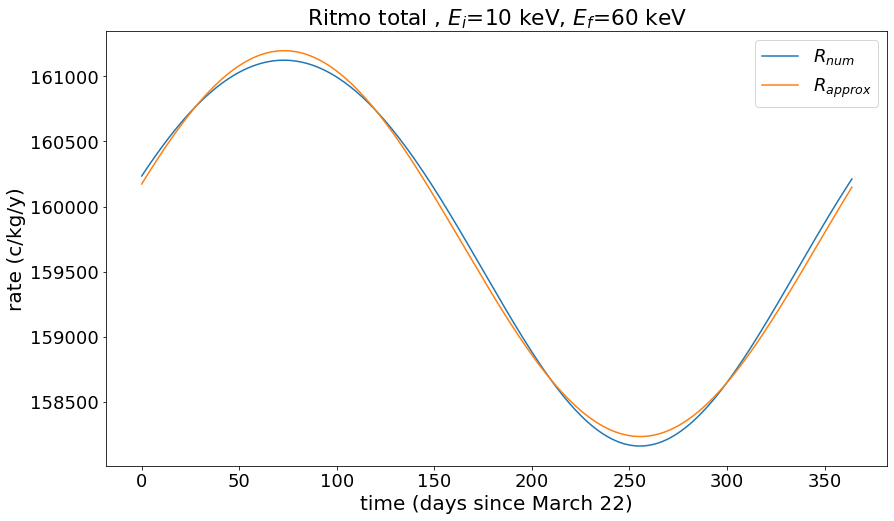

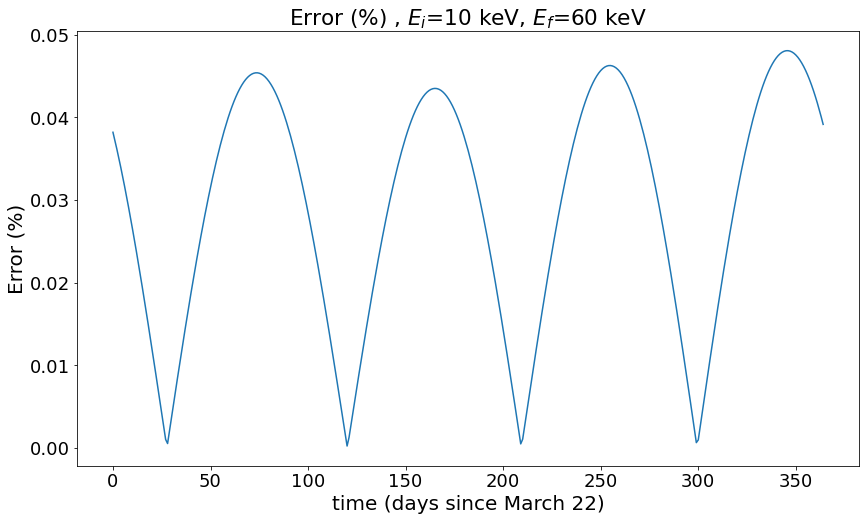

In [103]:
Ei=10
Ef=60

mW=70
si=1e-41 #seccion eficaz SI(cm^-2)
ritmosvstiempos=ratevsTimeNaI(Ei,Ef,mW,si)
R_max=np.max(ritmosvstiempos)
print('R_max = '+str(np.round(R_max)))
R_min=np.min(ritmosvstiempos)
print('R_min = '+str(np.round(R_min)))
R_0=np.mean(ritmosvstiempos)
print('R_0 = '+str(np.round(R_0)))
t_max=np.argmax(ritmosvstiempos)
print('t_max = '+str(t_max))

R_mod=0.5*(R_max-R_min)
omega=2*np.pi/365.

dias = np.arange(0,365)

rapprox=([(R_0+R_mod*np.cos(omega*(t-t_max))) for t in dias])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,ritmosvstiempos, label = "$R_{num}$")
ax.plot(dias,rapprox, label = "$R_{approx}$")
ax.set_title('Ritmo total , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('rate (c/kg/y)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
ax.legend()


err=([np.abs(((1-rapprox[t]/ritmosvstiempos[t]))*100) for t in dias])
print('Error = '+str(np.round(err[t_max],5)))

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,err, label = "$R_{num}$")
ax.set_title('Error (%) , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('Error (%)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
#ax.set_yscale("log")



En esta gráfica representamos el ritmo en función de la seccion eficaz para una masa de wimp concreta. (Trival porque la relacion es lineal, pero me sirvio para entender el concepto del diagrama de exclusión)

Text(0.5, 0, '$\\sigma_{SI}$ ($cm^2$)')

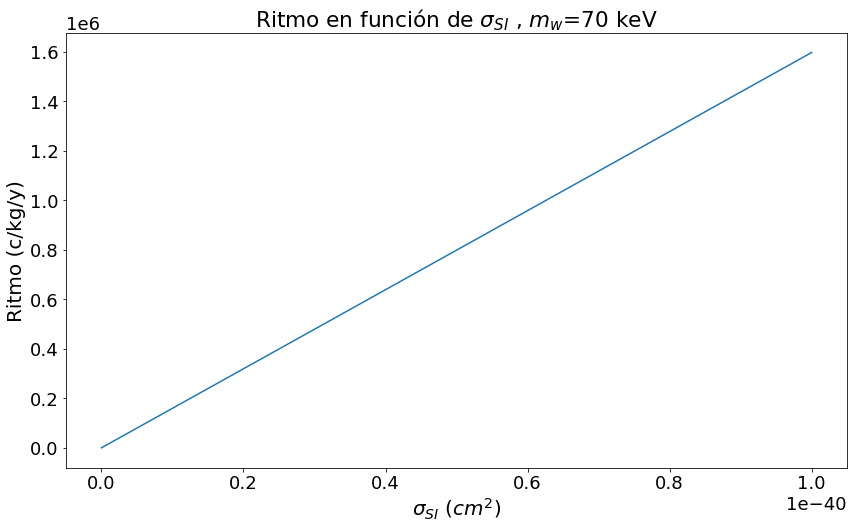

In [104]:
#Calculamos función Ritmo vs Seccion Eficaz

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW=70 

SIs= np.linspace(1e-40,1e-48,100)

R=np.array([totalRateNaI(10,60,timeAvg,mW,s) for s in SIs])


plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(SIs,R, label = "$R_{num}$")
ax.set_title('Ritmo en función de $\sigma_{SI}$ , $m_w$='+str(mW)+' keV')
ax.set_ylabel('Ritmo (c/kg/y)',fontsize=20)
ax.set_xlabel('$\sigma_{SI}$ ($cm^2$)',fontsize=20)
#ax.set_yscale("log")


En esta gráfica representamos el ritmo en función de la mas del wimp, dada una seccion eficaz concreta

Text(0.5, 0, '$m_w$ (GeV)')

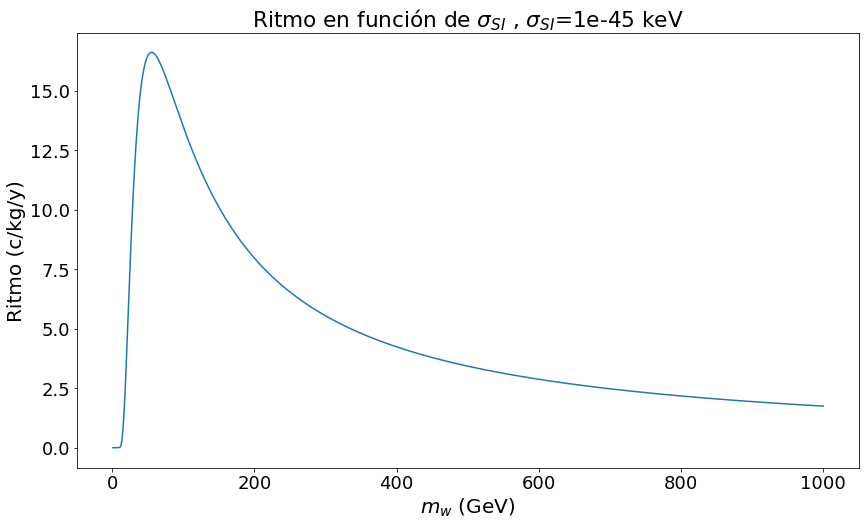

In [105]:
#Calculamos función Ritmo vs Masa Wimp

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

sigma_si=1e-45

mWs= np.linspace(1,1000,1000)

R=np.array([totalRateNaI(10,60,timeAvg,m,sigma_si) for m in mWs])


plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(mWs,R, label = "$R_{num}$")
ax.set_title('Ritmo en función de $\sigma_{SI}$ , $\sigma_{SI}$='+str(sigma_si)+' keV')
ax.set_ylabel('Ritmo (c/kg/y)',fontsize=20)
ax.set_xlabel('$m_w$ (GeV)',fontsize=20)
#ax.set_yscale("log")


En esta sección del codigo, vamos a extraer los datos del experimento, en formato .root emplenado la libreria uproot. 

Abrimos el archivo y vemos su estructura: con el comando file.keys(), vemos que hay 8 histogramas en su interior.

In [106]:
import uproot
file = uproot.open("BEhistos_year123456.root")
file.keys()

['hbea_123456y_D0;1',
 'hbea_123456y_D1;1',
 'hbea_123456y_D2;1',
 'hbea_123456y_D3;1',
 'hbea_123456y_D4;1',
 'hbea_123456y_D5;1',
 'hbea_123456y_D6;1',
 'hbea_123456y_D7;1',
 'hbea_123456y_D8;1',
 'hbea_123456y;1']

Empleamos el comando:  
 file["Nombre_del_Histograma"].all_members  
para ver el contenido de cada histograma

In [107]:
file["hbea_123456y_D0"].all_members

{'@fUniqueID': 0,
 '@fBits': 50332168,
 'fName': 'hbe0_year1_year6',
 'fTitle': '',
 'fLineColor': 600,
 'fLineStyle': 1,
 'fLineWidth': 2,
 'fFillColor': 0,
 'fFillStyle': 1001,
 'fMarkerColor': 600,
 'fMarkerStyle': 20,
 'fMarkerSize': 0.6000000238418579,
 'fNcells': 292,
 'fXaxis': <TAxis (version 10) at 0x7e1a2147b7c0>,
 'fYaxis': <TAxis (version 10) at 0x7e1a21440fd0>,
 'fZaxis': <TAxis (version 10) at 0x7e1a214405b0>,
 'fBarOffset': 0,
 'fBarWidth': 1000,
 'fEntries': 1802461.691594407,
 'fTsumw': 751.0752220746325,
 'fTsumw2': 0.3131543994404597,
 'fTsumwx': 9198.823684529332,
 'fTsumwx2': 166183.86047925722,
 'fMaximum': 16.0,
 'fMinimum': 0.0,
 'fNormFactor': 0.0,
 'fContour': <TArrayD [] at 0x7e1a214409d0>,
 'fSumw2': <TArrayD [0, 0.0131034, 0.00679434, ..., 0.000616966, 0.000634182, 0] at 0x7e1a21440670>,
 'fOption': <TString '' at 0x7e1a215dbe40>,
 'fFunctions': <TList of 0 items at 0x7e1a21477880>,
 'fBufferSize': 0,
 'fBuffer': array([], dtype=float64),
 'fBinStatErrOpt':

Empleamos el comando  
file["Nombre_del_Histograma"].axis().edges()  
para ver el valor del eje x de los bines del histograma

Empleamos el comando  
file["Nombre_del_Histograma"].values()  
para ver el valor del eje y de los bines del histograma

Empleamos el comando  
file["Nombre_del_Histograma"].errors()  
para ver el valor de la incertidumbre en el eje y de los bines del histograma

In [108]:
print(file["hbea_123456y_D0"].axis().edges())

[ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7
  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1
  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5
  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9
  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3
  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9
 15.  15.1 15.2 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3
 16.4 16.5 16.6 16.7 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7
 17.8 17.9 18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1
 19.2 19.3 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5
 20.6 

In [109]:
print(file["hbea_123456y_D0"].values())

[7.7058105 7.311093  6.7740903 6.026569  5.9330454 5.458445  5.353915
 5.0994816 5.0174937 5.035382  4.987608  4.839416  4.796341  5.030872
 4.986949  5.070045  5.2279673 5.4516573 5.517425  5.688737  5.6556563
 5.677316  5.6572313 5.5827994 5.4075494 5.2673492 4.9837985 4.815637
 4.549021  4.4147277 4.19852   4.0622582 3.8799195 3.850383  3.7479897
 3.7728004 3.6365385 3.595975  3.5904615 3.5888863 3.5073655 3.5109098
 3.4415975 3.415999  3.4254508 3.3317215 3.4333272 3.415999  3.3998523
 3.396308  3.347868  3.2943084 3.387644  3.4199371 3.2880073 3.2769804
 3.2950962 3.2549264 3.2320848 3.2037299 3.229722  3.1915214 3.1489887
 3.132842  3.170255  3.1060622 3.1320543 3.0973983 3.062742  3.0639236
 3.0658927 3.0706184 3.0135145 2.990279  3.0158775 3.0056381 2.992248
 2.9906728 2.9241173 2.924511  2.8993065 2.8752835 2.8382645 2.891824
 2.814635  2.8792217 2.8288126 2.8453531 2.8288126 2.8315694 2.7173615
 2.7847047 2.8083339 2.6913693 2.705153  2.7374463 2.7063346 2.7591064
 2.7126355 

Cargamos los datos de los histogramas en un array de numpy, La estructura del array es (por columnas):  

Eje_y_H0 Error_y_H0 Eje_y_H1 Error_y_H1 ... Eje_y_H8 Error_y_H8 Eje_x  

Las unidades de los datos del histograma son c/keV/Kg/year

In [110]:
longitud=290
es=np.arange(1,30,0.1)
datos=np.zeros((19,longitud))
for i in range (9):
    datos[2*i+1]=file["hbea_123456y_D"+str(i)].values()
    datos[2*i+2]=file["hbea_123456y_D"+str(i)].errors()
datos[0]=es
#np.savetxt("Exposicion_exp.csv",datos)   
    

Integramos los datos para obtener un valor del ritmo. Hacemos la integral desde 1 hasta 30 KeV.  
El resultado esta en c/Kg/year. En los errores se ha calculado la suma cuadratica de los errores de cada bin.

In [111]:
ritmos_exp=np.zeros(9)
errores_exp=np.zeros(9)
for i in range (9):
    ritmos_exp[i]=0
    errores_exp[i]=0
    for j in range(longitud):
        ritmos_exp[i]+=datos[2*i+1][j]
        errores_exp[i]+=datos[2*i+2][j]*datos[2*i+2][j]
    ritmos_exp[i]=ritmos_exp[i]*0.1
    errores_exp[i]=np.sqrt(errores_exp[i])*0.1
print(ritmos_exp)
print(errores_exp)

ritmo_exp=0
error_exp=0

for i in range (9):
    ritmo_exp+=ritmos_exp[i]
    error_exp+=(errores_exp[i]*errores_exp[i])
error_exp=np.sqrt(error_exp)

print(ritmo_exp)
print(error_exp)

[75.10753205 75.97939188 38.74051412 58.91472756 54.72537165 45.29965258
 41.26107051 37.59197367 32.70996918]
[0.0559602  0.0560157  0.04035848 0.05024415 0.04771208 0.04399458
 0.04141087 0.03948932 0.03703081]
4.6033020319938663e+02
0.13885278792894643


Generamos array con los tiempos de exposicion en dias

In [112]:
exposiciones=np.zeros(9) #dias
exposiciones[0]=2031.38
exposiciones[1]=2033.20
exposiciones[2]=2029.52
exposiciones[3]=2022.55
exposiciones[4]=2033.01
exposiciones[5]=2030.18
exposiciones[6]=2032.27 
exposiciones[7]=2031.02
exposiciones[8]=2020.29
#np.savetxt("exposiciones.csv",exposiciones)

dias=0

for i in range(9):
    dias+=exposiciones[i]

print(dias)

18263.420000000002


Calculamos el ritmo, multiplicando por el numero de dias y por la masa del detector. Cada detector son $12.5$ $Kg$

In [113]:
masa_detector=12.5*9

ritmo_exp_final=ritmo_exp*dias*masa_detector/365
error_exp_final=error_exp*dias*masa_detector/365

print(ritmo_exp_final)
print(error_exp_final)
print(np.sqrt(ritmo_exp_final))

2591261.4574466334
781.6212690772436
1609.7395619933782


Calculamos delta, el valor x para el que la integral gausiana desde -infinito hasta x es 0.9. Calculos en la hoja.

In [114]:
from scipy import special

significancia=0.9
print(2*significancia-1)
print(special.erf(0))
tes=np.arange(0.9061,0.9062,0.00000000019)
val=np.array([special.erf(e) for e in tes])

aux=0
for i in range (len(tes)):
    if val[i]>(2*significancia-1):
        aux=tes[i]
        print(tes[i-1])
        print(tes[i+1])
        print(tes[i-1]-tes[i+1])
        
        break

print(aux)

delta=aux*np.sqrt(2)*np.sqrt(ritmo_exp_final)
print(delta)

0.8
0.0
0.9061938022477612
0.9061938026277613
-3.80000031441341e-10
0.9061938024377613
2062.9642557938287


Calculo del plot de exclusion, generando un array (con distribucion logaritmica) de datos de masa de wimp, y calculando en cada uno la seccion eficaz en la que el ritmo experimental y el teorico coinciden. Para ello se calcula el ritmo teorico a seccion eficaz = 1 y luego se hace el cociente entre el ritmo experimental (teniendo en cuenta el margen del 0.9) y el ritmo teorico a seccion eficaz unidad.  

Se esta calculando usando las funciones teniendo en cuenta el QF desde 1 hasta 30 keV_ee

2593324.4217024273


/tmp/ipykernel_11805/1610496479.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_sis=np.array([(ritmo_comp/totalRate_NaI_ee(1,30,timeAvg,a,1)) for a in mWs])


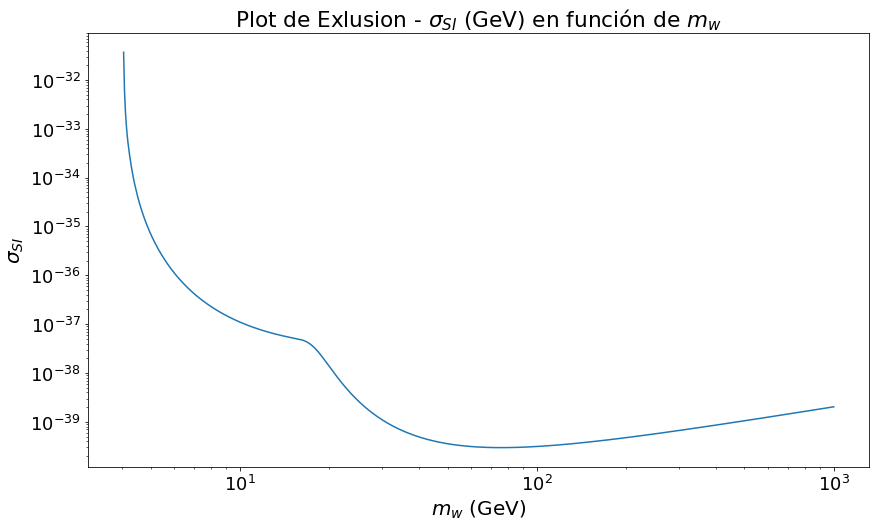

In [115]:
ritmo_comp=ritmo_exp_final+delta
print(ritmo_comp)

#Calculamos función Ritmo teorico

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW_min=0.1 #masa wimp minima en GeV
mW_max=3
mWs=np.logspace(mW_min,mW_max,num=1000,endpoint=True)

sigma_sis=np.array([(ritmo_comp/totalRate_NaI_ee(1,30,timeAvg,a,1)) for a in mWs])


plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(mWs,sigma_sis)
ax.set_title('Plot de Exlusion - $\sigma_{SI}$ (GeV) en función de $m_w$')
ax.set_ylabel('$\sigma_{SI}$',fontsize=20)
ax.set_xlabel('$m_w$ (GeV)',fontsize=20)
ax.set_yscale("log")
ax.set_xscale("log")


Calculo del plot de exclusion, generando un array (con distribucion logaritmica) de datos de masa de wimp, y calculando en cada uno la seccion eficaz en la que el ritmo experimental y el teorico coinciden. Para ello se calcula el ritmo teorico a seccion eficaz = 1 y luego se hace el cociente entre el ritmo experimental (teniendo en cuenta el margen del 0.9) y el ritmo teorico a seccion eficaz unidad.  

Se esta calculando usando las funciones sin tener en cuenta el QF desde 1 hasta 30 keV

2.5933244217024273e+06


/tmp/ipykernel_11805/2541375089.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_sis=np.array([(ritmo_comp/totalRateNaI(1,30,timeAvg,a,1)) for a in mWs])


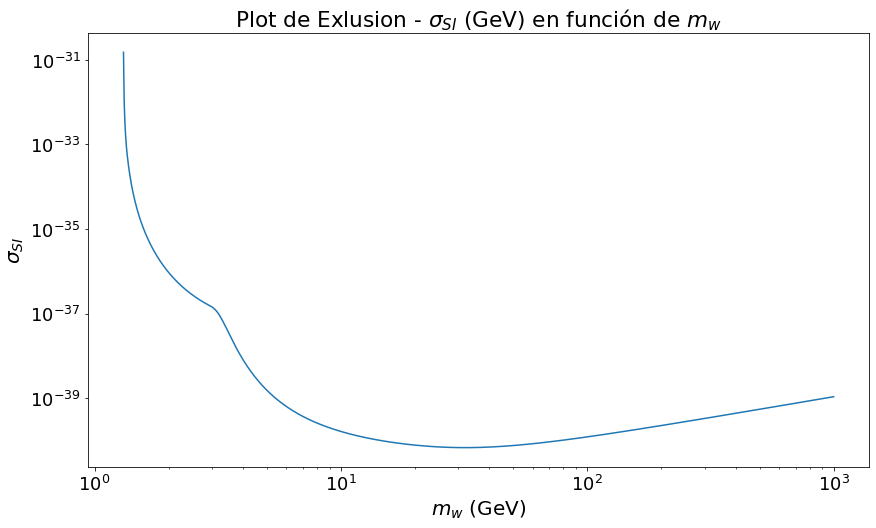

In [116]:
ritmo_comp=ritmo_exp_final+delta
print(ritmo_comp)

#Calculamos función Ritmo teorico

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW_min=0.1 #masa wimp minima en GeV
mW_max=3
mWs=np.logspace(mW_min,mW_max,num=1000,endpoint=True)

sigma_sis=np.array([(ritmo_comp/totalRateNaI(1,30,timeAvg,a,1)) for a in mWs])


plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(mWs,sigma_sis)
ax.set_title('Plot de Exlusion - $\sigma_{SI}$ (GeV) en función de $m_w$')
ax.set_ylabel('$\sigma_{SI}$',fontsize=20)
ax.set_xlabel('$m_w$ (GeV)',fontsize=20)
ax.set_yscale("log")
ax.set_xscale("log")